Récupération des données



In [ ]:
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls "/content/gdrive/MyDrive/Colab Notebooks"

eye_images_3x3.npy  eye_state.npy  NotebookColab.ipynb
eye_images.npy	    model.h5


In [ ]:
y = np.load('/content/gdrive/MyDrive/Colab Notebooks/eye_state.npy')

In [ ]:
y.shape

(84898,)

In [ ]:
img = np.load('/content/gdrive/MyDrive/Colab Notebooks/eye_images.npy')

In [ ]:
img.shape

(84898, 28, 28)

In [96]:
X = np.expand_dims(img, axis=3)
X.shape

(84898, 28, 28, 1)

Modèle de CNN 

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

def initialize_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
    #model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    #model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (2, 2), activation='relu', padding='same'))
    #model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


def initialize_model_simple():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [ ]:
model = initialize_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)        

In [ ]:
from tensorflow.keras import optimizers

def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model_small = compile_model(model)

Séparation X_train / X_test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [76]:
X_train.shape

(63673, 28, 28, 1)

In [ ]:
reduction_factor = 1

idx_train =  np.random.choice(len(X_train), round(len(X_train)/reduction_factor))

images_train_small = X_train[idx_train]
labels_train_small = y_train[idx_train]

print(images_train_small.shape)
print(labels_train_small.shape)
print(type(images_train_small))
print(type(labels_train_small))

(63673, 28, 28, 1)
(63673,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
y

array([0, 0, 0, ..., 1, 1, 1])

Entrainement du modèle

In [54]:
es = EarlyStopping(patience=5, verbose=2, restore_best_weights=True)

history_small = model_small.fit(images_train_small, labels_train_small, 
                    validation_split=0.3,
                    callbacks=[es], 
                    epochs=100, 
                    batch_size=64)

Epoch 1/100
697/697 [==============================] - 80s 113ms/step - loss: 0.2881 - accuracy: 0.8775 - val_loss: 0.1654 - val_accuracy: 0.9464
Epoch 2/100
697/697 [==============================] - 78s 112ms/step - loss: 0.1449 - accuracy: 0.9460 - val_loss: 0.1282 - val_accuracy: 0.9542
Epoch 3/100
697/697 [==============================] - 77s 111ms/step - loss: 0.1154 - accuracy: 0.9573 - val_loss: 0.0895 - val_accuracy: 0.9698
Epoch 4/100
697/697 [==============================] - 78s 112ms/step - loss: 0.0995 - accuracy: 0.9634 - val_loss: 0.0672 - val_accuracy: 0.9754
Epoch 5/100
697/697 [==============================] - 83s 120ms/step - loss: 0.0875 - accuracy: 0.9676 - val_loss: 0.0677 - val_accuracy: 0.9758
Epoch 6/100
697/697 [==============================] - 79s 113ms/step - loss: 0.0819 - accuracy: 0.9701 - val_loss: 0.0576 - val_accuracy: 0.9799
Epoch 7/100
697/697 [==============================] - 79s 113ms/step - loss: 0.0726 - accuracy: 0.9734 - val_loss: 0.0584 -

In [77]:
y.shape

(84898,)

Learning curves

In [57]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

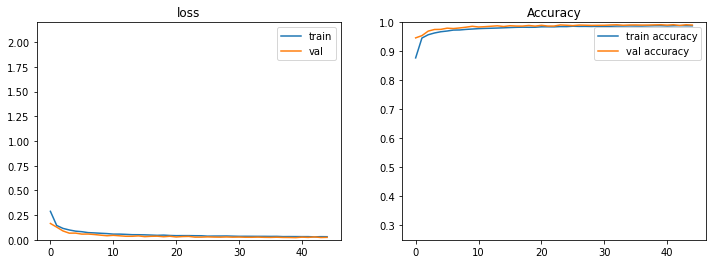

In [58]:
import matplotlib.pyplot as plt
plot_history(history_small)
plt.show()

Evaluation results

In [105]:
res = model_small.evaluate(X_test, y_test, verbose=0)
res

[0.0327405110001564, 0.9872791767120361]

In [107]:
import pandas as pd
y_pred = model_small.predict(X_test)
y_pred

array([[1.0000000e+00],
       [8.1679225e-04],
       [1.0000000e+00],
       ...,
       [1.0000000e+00],
       [4.0371619e-06],
       [3.6966685e-06]], dtype=float32)

In [110]:
def binarize(predictions):
  return [1 if p > 0.5 else 0 for p in predictions]

y_pred_binarized = binarize(y_pred)

[1.] 1


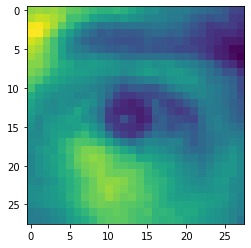

In [123]:
j=0
plt.imshow(X_test[j][:,:,0])
print(y_pred[j], y_test[j])

Enregistrement du modèle

In [124]:
model_small.save("/content/gdrive/MyDrive/Colab Notebooks/model.h5")

In [125]:
from tensorflow import keras as K

model_loaded2 = K.models.load_model("/content/gdrive/MyDrive/Colab Notebooks/model.h5")

In [126]:
y_pred2 = model_loaded2.predict(X_test)

In [127]:
y_pred2

array([[1.0000000e+00],
       [8.1679225e-04],
       [1.0000000e+00],
       ...,
       [1.0000000e+00],
       [4.0371619e-06],
       [3.6966685e-06]], dtype=float32)

In [128]:
def binarize(predictions):
  return [1 if p > 0.5 else 0 for p in predictions]

predictions = model.predict(X_test)

y_pred_binarized = binarize(predictions)